Spooky Author Identification
=============

Text Features
------------

This notebook will be used to create text features, including tf-idf, term frequencies and LDA topic modeling for the sentences, and fit models like Naive Bayes, XGBoost etc. to predict the authors. 

The tf-idf and term frequencies will be very sparse, thus the feature space will be too large if we directly use them as features. Instead, we could use the tf-idf and term frequencies to train separate Naive Bayes models to predict the probabilities for each sentence, and then use the probabilities as features to train XGBoost model to predict the authors.

In [2]:
# All the modules that will be used later
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn import model_selection, metrics
import xgboost as xgb
import itertools

Read the train and test sets which include the sentence statistics features created in Notebook 1.

In [3]:
train = pd.read_csv('train_features.csv')
test = pd.read_csv('test_features.csv')
# Drop the first unnamed column
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)
print('Train data size: ', train.shape)
print('Test data size: ', test.shape)

Train data size:  (19579, 10)
Test data size:  (8392, 9)


In [4]:
# Class labels
author_mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y = train['author'].map(author_mapping)
y.shape

(19579,)

Tf-idf Features
--------------

Let's first compute the tf-idf values for words in the sentences.

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, 
                                   ngram_range = (1, 3), stop_words = 'english')
all_tfidf = tfidf_vectorizer.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vectorizer.transform(train['text'].values.tolist())
test_tfidf = tfidf_vectorizer.transform(test['text'].values.tolist())
print('Train word tfidf size: ', train_tfidf.shape)
print('Test word tfidf size: ', test_tfidf.shape)

Train word tfidf size:  (19579, 39026)
Test word tfidf size:  (8392, 39026)


Then we can fit a Naive Bayes using the tf-idf values as features, as Naive Bayes sometimes gives good performance on high-dimensional text data, and is easy to train. Let's check its performance with cross-validation log-loss.

In [6]:
# Run a 10-fold cross-validation using train set
log_loss = []
train_pred = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_tfidf[dev_idx], train_tfidf[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    nb = naive_bayes.MultinomialNB()
    nb.fit(X_dev, y_dev)
    y_pred = nb.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.602685263621


The log-loss dropped to 0.60 by using tf-idf values! That's a big improvement compared to using sentence statistics features. Let's plot the confusion matrix.

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[687  28  67]
 [129 400  37]
 [ 82  16 511]]


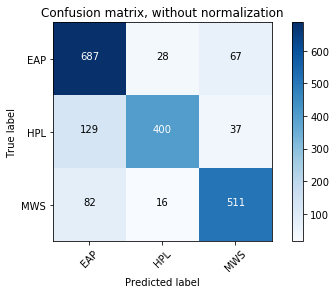

In [8]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

HPL is prone to be misclassified as EAP, also, EAP and MWS seem to be confusing to the model. Now let's fit a Naive Bayes model using all train data, and apply it to predict probabilities for the test set. These probabilities will be used as new features.

In [9]:
# Add the probabilities to features of train set
train['tfidf_word_EAP'] = train_pred[:, 0]
train['tfidf_word_HPL'] = train_pred[:, 1]
train['tfidf_word_MWS'] = train_pred[:, 2]

In [10]:
# Fit a Naive Bayes model using the entire train set
nb = naive_bayes.MultinomialNB()
nb.fit(train_tfidf, y)
test_pred = nb.predict_proba(test_tfidf)

# Add the probabilities to features of test set
test['tfidf_word_EAP'] = test_pred[:, 0]
test['tfidf_word_HPL'] = test_pred[:, 1]
test['tfidf_word_MWS'] = test_pred[:, 2]

In addition to the probabilities, we can also apply SVD on tfidf matrix to reduce its dimensionality, and add the leading components as features. Here we use 50 leading components, and the number of leading components is a hyperparameter which could be tuned.

In [11]:
svd = TruncatedSVD(n_components = 50, algorithm = 'arpack')
svd.fit(all_tfidf)
train_tfidf_svd = pd.DataFrame(svd.transform(train_tfidf))
test_tfidf_svd = pd.DataFrame(svd.transform(test_tfidf))
train_tfidf_svd.columns = ['tfidf_word_svd_' + str(i) for i in range(50)]
test_tfidf_svd.columns = ['tfidf_word_svd_' + str(i) for i in range(50)]
train = pd.concat([train, train_tfidf_svd], axis = 1)
test = pd.concat([test, test_tfidf_svd], axis = 1)

Then let's compute the tf-idf values for characters in the sentences.

In [12]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 5), analyzer = 'char')
all_tfidf = tfidf_vectorizer.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vectorizer.transform(train['text'].values.tolist())
test_tfidf = tfidf_vectorizer.transform(test['text'].values.tolist())
print('Train character tfidf size: ', train_tfidf.shape)
print('Test character tfidf size: ', test_tfidf.shape)

Train character tfidf size:  (19579, 215829)
Test character tfidf size:  (8392, 215829)


Then let's also fit a Naive Bayes using the tf-idf values of characters as features.

In [13]:
# Run a 10-fold cross-validation using train set
log_loss = []
train_pred = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_tfidf[dev_idx], train_tfidf[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    nb = naive_bayes.MultinomialNB()
    nb.fit(X_dev, y_dev)
    y_pred = nb.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.756576465068


The log-loss is higher than the word-level tfidf. Let's check the confusion matrix.

Confusion matrix, without normalization
[[757  11  14]
 [387 165  14]
 [274   5 330]]


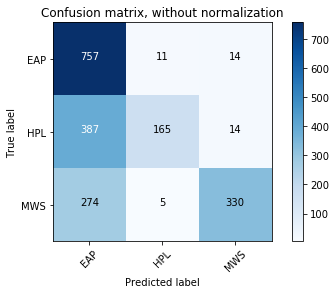

In [14]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

The character-level tfidf does a better job in identifying EAP from the other two authors than the word-level tfidf. If we combine them, we might achieve even better performance.

In [15]:
# Add the probabilities to features of train set
train['tfidf_char_EAP'] = train_pred[:, 0]
train['tfidf_char_HPL'] = train_pred[:, 1]
train['tfidf_char_MWS'] = train_pred[:, 2]

In [16]:
# Fit a Naive Bayes model using the entire train set
nb = naive_bayes.MultinomialNB()
nb.fit(train_tfidf, y)
test_pred = nb.predict_proba(test_tfidf)

# Add the probabilities to features of test set
test['tfidf_char_EAP'] = test_pred[:, 0]
test['tfidf_char_HPL'] = test_pred[:, 1]
test['tfidf_char_MWS'] = test_pred[:, 2]

In [17]:
# Add the leading SVD components as features
svd = TruncatedSVD(n_components = 50, algorithm = 'arpack')
svd.fit(all_tfidf)
train_tfidf_svd = pd.DataFrame(svd.transform(train_tfidf))
test_tfidf_svd = pd.DataFrame(svd.transform(test_tfidf))
train_tfidf_svd.columns = ['tfidf_char_svd_' + str(i) for i in range(50)]
test_tfidf_svd.columns = ['tfidf_char_svd_' + str(i) for i in range(50)]
train = pd.concat([train, train_tfidf_svd], axis = 1)
test = pd.concat([test, test_tfidf_svd], axis = 1)

Term Frequency Features
--------------

Then let's try the term frequencies for words in the sentences.

In [18]:
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, ngram_range = (1, 3), stop_words = 'english')
all_tf = tf_vectorizer.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tf = tf_vectorizer.transform(train['text'].values.tolist())
test_tf = tf_vectorizer.transform(test['text'].values.tolist())
print('Train word tf size: ', train_tf.shape)
print('Test word tf size: ', test_tf.shape)

Train word tf size:  (19579, 39026)
Test word tf size:  (8392, 39026)


Then let's fit a Naive Bayes using the term frequency values as features, and check its cross-validation log-loss.

In [19]:
# Run a 10-fold cross-validation using train set
log_loss = []
train_pred = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_tf[dev_idx], train_tf[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    nb = naive_bayes.MultinomialNB()
    nb.fit(X_dev, y_dev)
    y_pred = nb.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.45148570549


The log-loss is only 0.45 now! Let's plot the confusion matrix.

Confusion matrix, without normalization
[[624  50 108]
 [ 59 468  39]
 [ 47  28 534]]


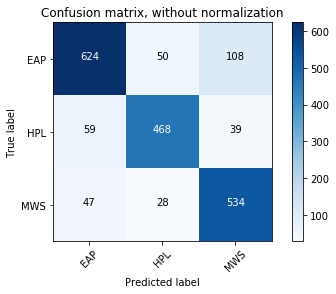

In [20]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

This time, EAP is prone to be misclassified as MWS. Term frequency seems to be addressing different issues from tfidf. Now let's add the probabilities predicted by Naive Bayes model trained on the entire train set as new features for test set.

In [21]:
# Add the probabilities to features of train set
train['tf_word_EAP'] = train_pred[:, 0]
train['tf_word_HPL'] = train_pred[:, 1]
train['tf_word_MWS'] = train_pred[:, 2]

In [22]:
nb = naive_bayes.MultinomialNB()
nb.fit(train_tf, y)
test_pred = nb.predict_proba(test_tf)

# Add the probabilities to features of test set
test['tf_word_EAP'] = test_pred[:, 0]
test['tf_word_HPL'] = test_pred[:, 1]
test['tf_word_MWS'] = test_pred[:, 2]

In [23]:
# Add the leading SVD components as features
svd = TruncatedSVD(n_components = 50, algorithm = 'arpack')
svd.fit(all_tf)
train_tf_svd = pd.DataFrame(svd.transform(train_tf))
test_tf_svd = pd.DataFrame(svd.transform(test_tf))
train_tf_svd.columns = ['tf_word_svd_' + str(i) for i in range(50)]
test_tf_svd.columns = ['tf_word_svd_' + str(i) for i in range(50)]
train = pd.concat([train, train_tf_svd], axis = 1)
test = pd.concat([test, test_tf_svd], axis = 1)

Then let's also fit a Naive Bayes using the character frequencies as features.

In [24]:
tf_vectorizer = CountVectorizer(ngram_range = (1, 5), analyzer = 'char')
all_tf = tf_vectorizer.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tf = tf_vectorizer.transform(train['text'].values.tolist())
test_tf = tf_vectorizer.transform(test['text'].values.tolist())
print('Train character tf size: ', train_tf.shape)
print('Test character tf size: ', test_tf.shape)

Train character tf size:  (19579, 215829)
Test character tf size:  (8392, 215829)


In [25]:
# Run a 10-fold cross-validation using train set
log_loss = []
train_pred = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_tf[dev_idx], train_tf[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    nb = naive_bayes.MultinomialNB()
    nb.fit(X_dev, y_dev)
    y_pred = nb.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 3.11776367802


The log-loss is very high this time. Let's plot the confusion matrix.

Confusion matrix, without normalization
[[618  78  86]
 [ 73 451  42]
 [ 47  35 527]]


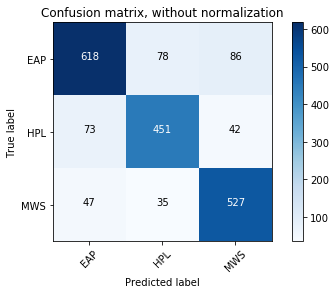

In [26]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

In [27]:
# Add the probabilities to features of train set
train['tf_char_EAP'] = train_pred[:, 0]
train['tf_char_HPL'] = train_pred[:, 1]
train['tf_char_MWS'] = train_pred[:, 2]

In [28]:
nb = naive_bayes.MultinomialNB()
nb.fit(train_tf, y)
test_pred = nb.predict_proba(test_tf)

# Add the probabilities to features of test set
test['tf_char_EAP'] = test_pred[:, 0]
test['tf_char_HPL'] = test_pred[:, 1]
test['tf_char_MWS'] = test_pred[:, 2]

In [29]:
# Add the leading SVD components as features
svd = TruncatedSVD(n_components = 50, algorithm = 'arpack')
svd.fit(all_tf)
train_tf_svd = pd.DataFrame(svd.transform(train_tf))
test_tf_svd = pd.DataFrame(svd.transform(test_tf))
train_tf_svd.columns = ['tf_char_svd_' + str(i) for i in range(50)]
test_tf_svd.columns = ['tf_char_svd_' + str(i) for i in range(50)]
train = pd.concat([train, train_tf_svd], axis = 1)
test = pd.concat([test, test_tf_svd], axis = 1)

Topic Modeling
--------------

Now let's try topic modeling with LDA. Similarly, we still fit a Naive Bayes using the topics as features, and add the probabilities predicted by the model trained on all train data as new features for test set.

In [30]:
tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, ngram_range = (1, 3), stop_words = 'english')
all_tf = tf_vectorizer.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tf = tf_vectorizer.transform(train['text'].values.tolist())
test_tf = tf_vectorizer.transform(test['text'].values.tolist())
lda = LatentDirichletAllocation(n_topics = 10, max_iter = 5, learning_method = 'online', 
                                learning_offset = 50., random_state = 1001)
all_lda = lda.fit_transform(all_tf)
train_lda = lda.transform(train_tf)
test_lda = lda.transform(test_tf)
print('Train lda size: ', train_lda.shape)
print('Test lda size: ', test_lda.shape)

Train lda size:  (19579, 10)
Test lda size:  (8392, 10)


In [31]:
# Run a 10-fold cross-validation using train set
log_loss = []
train_pred = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_lda[dev_idx], train_lda[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    nb = naive_bayes.MultinomialNB()
    nb.fit(X_dev, y_dev)
    y_pred = nb.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 1.06493844307


Confusion matrix, without normalization
[[775   4   3]
 [554  12   0]
 [608   1   0]]


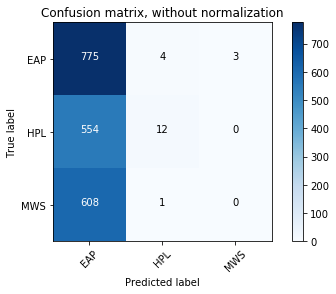

In [32]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

The model gives a high log-loss and seems to predict every sentence to EAP. However, as it might provide additional information to tf-idf and term frequencies, let's just keep it.

In [33]:
# Add the probabilities to features of train set
train['lda_EAP'] = train_pred[:, 0]
train['lda_HPL'] = train_pred[:, 1]
train['lda_MWS'] = train_pred[:, 2]

In [34]:
nb = naive_bayes.MultinomialNB()
nb.fit(train_lda, y)
test_pred = nb.predict_proba(test_lda)

# Add the probabilities to features of test set
test['lda_EAP'] = test_pred[:, 0]
test['lda_HPL'] = test_pred[:, 1]
test['lda_MWS'] = test_pred[:, 2]

Let's save the features for future use.

In [35]:
train.to_csv('train_features.csv')
test.to_csv('test_features.csv')

Model with Combined Features
------------

Now let's use the sentence statistics and text features we have created so far and train a xgboost model on them.

In [36]:
def run_xgboost(X_train, y_train, X_val):
    param = {'silent': 1, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5,
             'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 1001}
    plst = param.items()
    num_round = 1000
    dtrain = xgb.DMatrix(X_train, label = y_train)
    model = xgb.train(plst, dtrain, num_round)
    dtest = xgb.DMatrix(X_val)
    y_pred = model.predict(dtest, ntree_limit = model.best_ntree_limit)
    return model, y_pred

In [37]:
# Features
X = train.drop(['id', 'text', 'author'], axis = 1)
X.shape

(19579, 222)

In [38]:
# Run a 10-fold cross-validation using train set
log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(X):
    X_dev, X_val = X.iloc[dev_idx], X.iloc[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    model, y_pred = run_xgboost(X_dev, y_dev, X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.325717551979


The log-loss is only 0.33 now. Let's fit XGBoost model using all the train data and predict the authors for the test set.

In [39]:
# Features of test set
X_test = test.drop(['id', 'text'], axis = 1)
X_test.shape

(8392, 222)

In [40]:
model, test_prob = run_xgboost(X, y, X_test)

Then we merge the id and prediction of the test set and submit it to kaggle. The score is 0.32536, much better than what we achieved in Notebook 1.

In [41]:
sub_id = test['id'].values.reshape((len(test['id']), 1))
submission = np.concatenate((sub_id, test_prob), axis = 1)
submission = pd.DataFrame(submission, columns = ['id', 'EAP', 'HPL', 'MWS'])
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.00531819,0.000372162,0.99431
1,id24541,0.999815,0.000130633,5.46674e-05
2,id00134,0.0122961,0.9859,0.0018042
3,id27757,0.554181,0.443798,0.00202074
4,id04081,0.970684,0.0248762,0.00444029


In [42]:
submission.to_csv('submission.csv')

Reference
---------

[1] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

[2] https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

[3] http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

[4] https://www.kaggle.com/skrcode/0-29-public-lb-score-beginner-nlp-tutorial